In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(unglue))
theme_set(theme_classic(22))

In [2]:
#paths to files
files <- fs::dir_ls("output/sweep_regions", regexp = "csv$")
#extract variables from path names
unglue_str <- "output/sweep_regions/rep-{rep}_seed1-{seed1}_seed2-{seed2}_startfreq-{start_freq}_endfreq-{end_freq}_alpha-{alpha}_sub-{sub}.csv"
metadata_df <- map_df(files, ~ {
    df  <- unglue(.x, unglue_str)[[1]]
    mutate(df, file = .x)
})

#merge all the sweep regions and classify sim type
full_df <- map(files, ~ {
    suppressMessages(
        vroom::vroom(.x) %>% 
        mutate(file = .x) %>% 
        filter_all(any_vars(!is.na(.)))
    )
}) %>% 
reduce(bind_rows) %>% 
inner_join(., metadata_df, by = "file") %>% 
mutate(sim_type = 
    case_when(
        alpha == "0" ~ "neutral",
        start_freq == "0.0" & end_freq == "0.999" ~ "hard",
        end_freq == "0.5" ~ "incomplete",
        start_freq != "0.999" & !is.na(start_freq) ~ "soft"
    )
) %>% 
    arrange(sweep_size) %>% 
    filter(alpha != '0') %>% 
    group_by(alpha, sim_type) %>% 
    mutate(
        specificity_1m = 1 - cumsum(truth_class == "false_positive")/sum(truth_class == "false_positive", na.rm = TRUE) #cumulative false pos fraction
    )  %>% 
    arrange(specificity_1m) %>% 
    mutate(sensitivity = cumsum(truth_class == "true_positive")/sum(truth_class == "true_positive", na.rm = TRUE), #cumulative true pos fraction
    )


In [3]:
head(full_df)

...1,chromosome,sweep_group,start,end,sweep_size,true_covered,truth_class,type,file,rep,seed1,seed2,start_freq,end_freq,alpha,sub,sim_type,specificity_1m,sensitivity
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fs::path>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,chrom_NAN,0,206326,244479,38153,0,false_positive,NA,output/sweep_regions/rep-933_seed1-33968_seed2-12331_startfreq-0.0_endfreq-0.999_alpha-10_sub-1.csv,933,33968,12331,0.0,0.999,10,1,hard,0,0.000000000
2,chrom_NAN,1,261956,300702,38746,0,false_positive,NA,output/sweep_regions/rep-227_seed1-35067_seed2-37599_startfreq-0.03257785302749494_endfreq-0.999_alpha-100_sub-1.csv,227,35067,37599,0.03257785302749494,0.999,100,1,soft,0,0.000000000
1,chrom_NAN,0,190654,229617,38963,1,true_positive,NA,output/sweep_regions/rep-519_seed1-28980_seed2-20705_startfreq-0.04245010100211793_endfreq-0.999_alpha-100_sub-1.csv,519,28980,20705,0.04245010100211793,0.999,100,1,soft,0,0.003154574
1,chrom_NAN,0,170895,209984,39089,1,true_positive,NA,output/sweep_regions/rep-1131_seed1-36884_seed2-16695_startfreq-0.018823348351892793_endfreq-0.999_alpha-100_sub-1.csv,1131,36884,16695,0.018823348351892793,0.999,100,1,soft,0,0.006309148
1,chrom_NAN,0,183337,223231,39894,1,true_positive,NA,output/sweep_regions/rep-811_seed1-28577_seed2-23067_startfreq-0.008487461850185996_endfreq-0.999_alpha-100_sub-1.csv,811,28577,23067,0.008487461850185996,0.999,100,1,soft,0,0.009463722
1,chrom_NAN,0,166647,206699,40052,1,true_positive,NA,output/sweep_regions/rep-1111_seed1-1260_seed2-36485_startfreq-0.008487461850185996_endfreq-0.999_alpha-100_sub-2.csv,1111,1260,36485,0.008487461850185996,0.999,100,2,soft,0,0.012618297


Warning message:
“Removed 36 row(s) containing missing values (geom_path).”


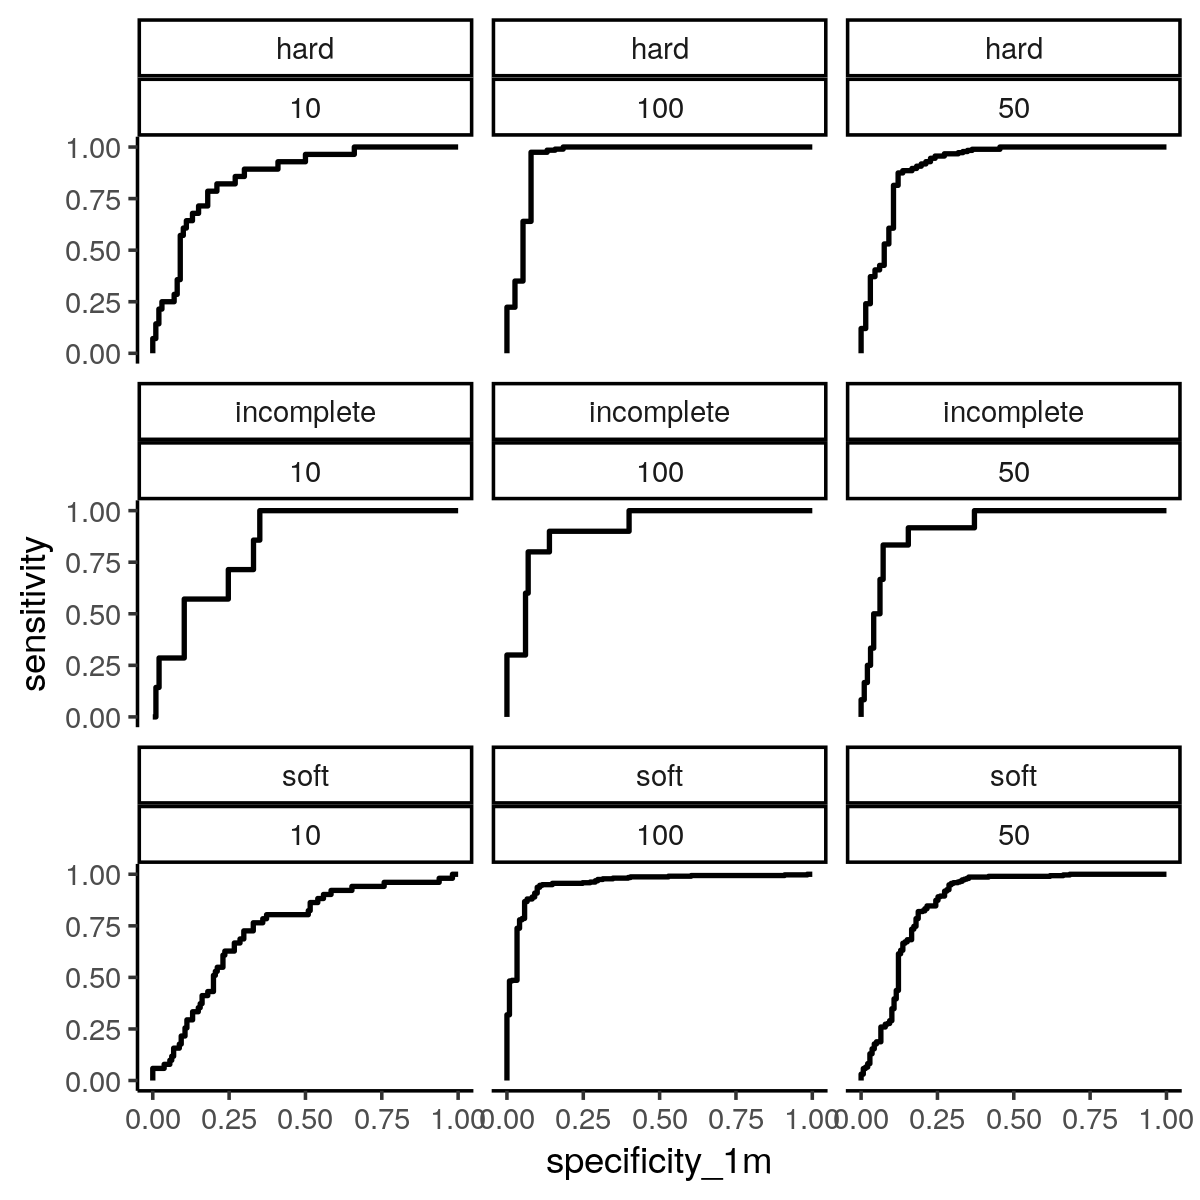

In [4]:
options(repr.plot.width=10, repr.plot.height=10)

full_df %>%
    arrange(sensitivity) %>% 
    ggplot(aes(specificity_1m, sensitivity)) +
    geom_line(lwd = 1.5) +
    facet_wrap(~sim_type + alpha)

In [5]:
full_df %>% 
    group_by(alpha, sim_type) %>% 
    summarise(
        FPR = mean(truth_class == "false_positive", na.rm = TRUE),
        TPR = mean(truth_class == "true_positive", na.rm = TRUE),
        TNR = mean(truth_class == "true_negative", na.rm = TRUE),
        FNR = mean(truth_class == "false_negative", na.rm = TRUE)  
    )

`summarise()` has grouped output by 'alpha'. You can override using the `.groups` argument.



alpha,sim_type,FPR,TPR,TNR,FNR
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
10,hard,0.20000000,0.05600000,0.4000000,0.344000000
10,incomplete,0.19517103,0.01408451,0.4024145,0.388329980
10,soft,0.17145900,0.05431310,0.4132055,0.361022364
100,hard,0.08715596,0.45183486,0.4564220,0.004587156
100,incomplete,0.22417154,0.01949318,0.3859649,0.370370370
100,soft,0.13340684,0.34950386,0.4332966,0.083792723
50,hard,0.14163090,0.39270386,0.4291845,0.036480687
50,incomplete,0.19595960,0.02424242,0.4000000,0.379797980
50,soft,0.15092291,0.31813246,0.4245385,0.106406080


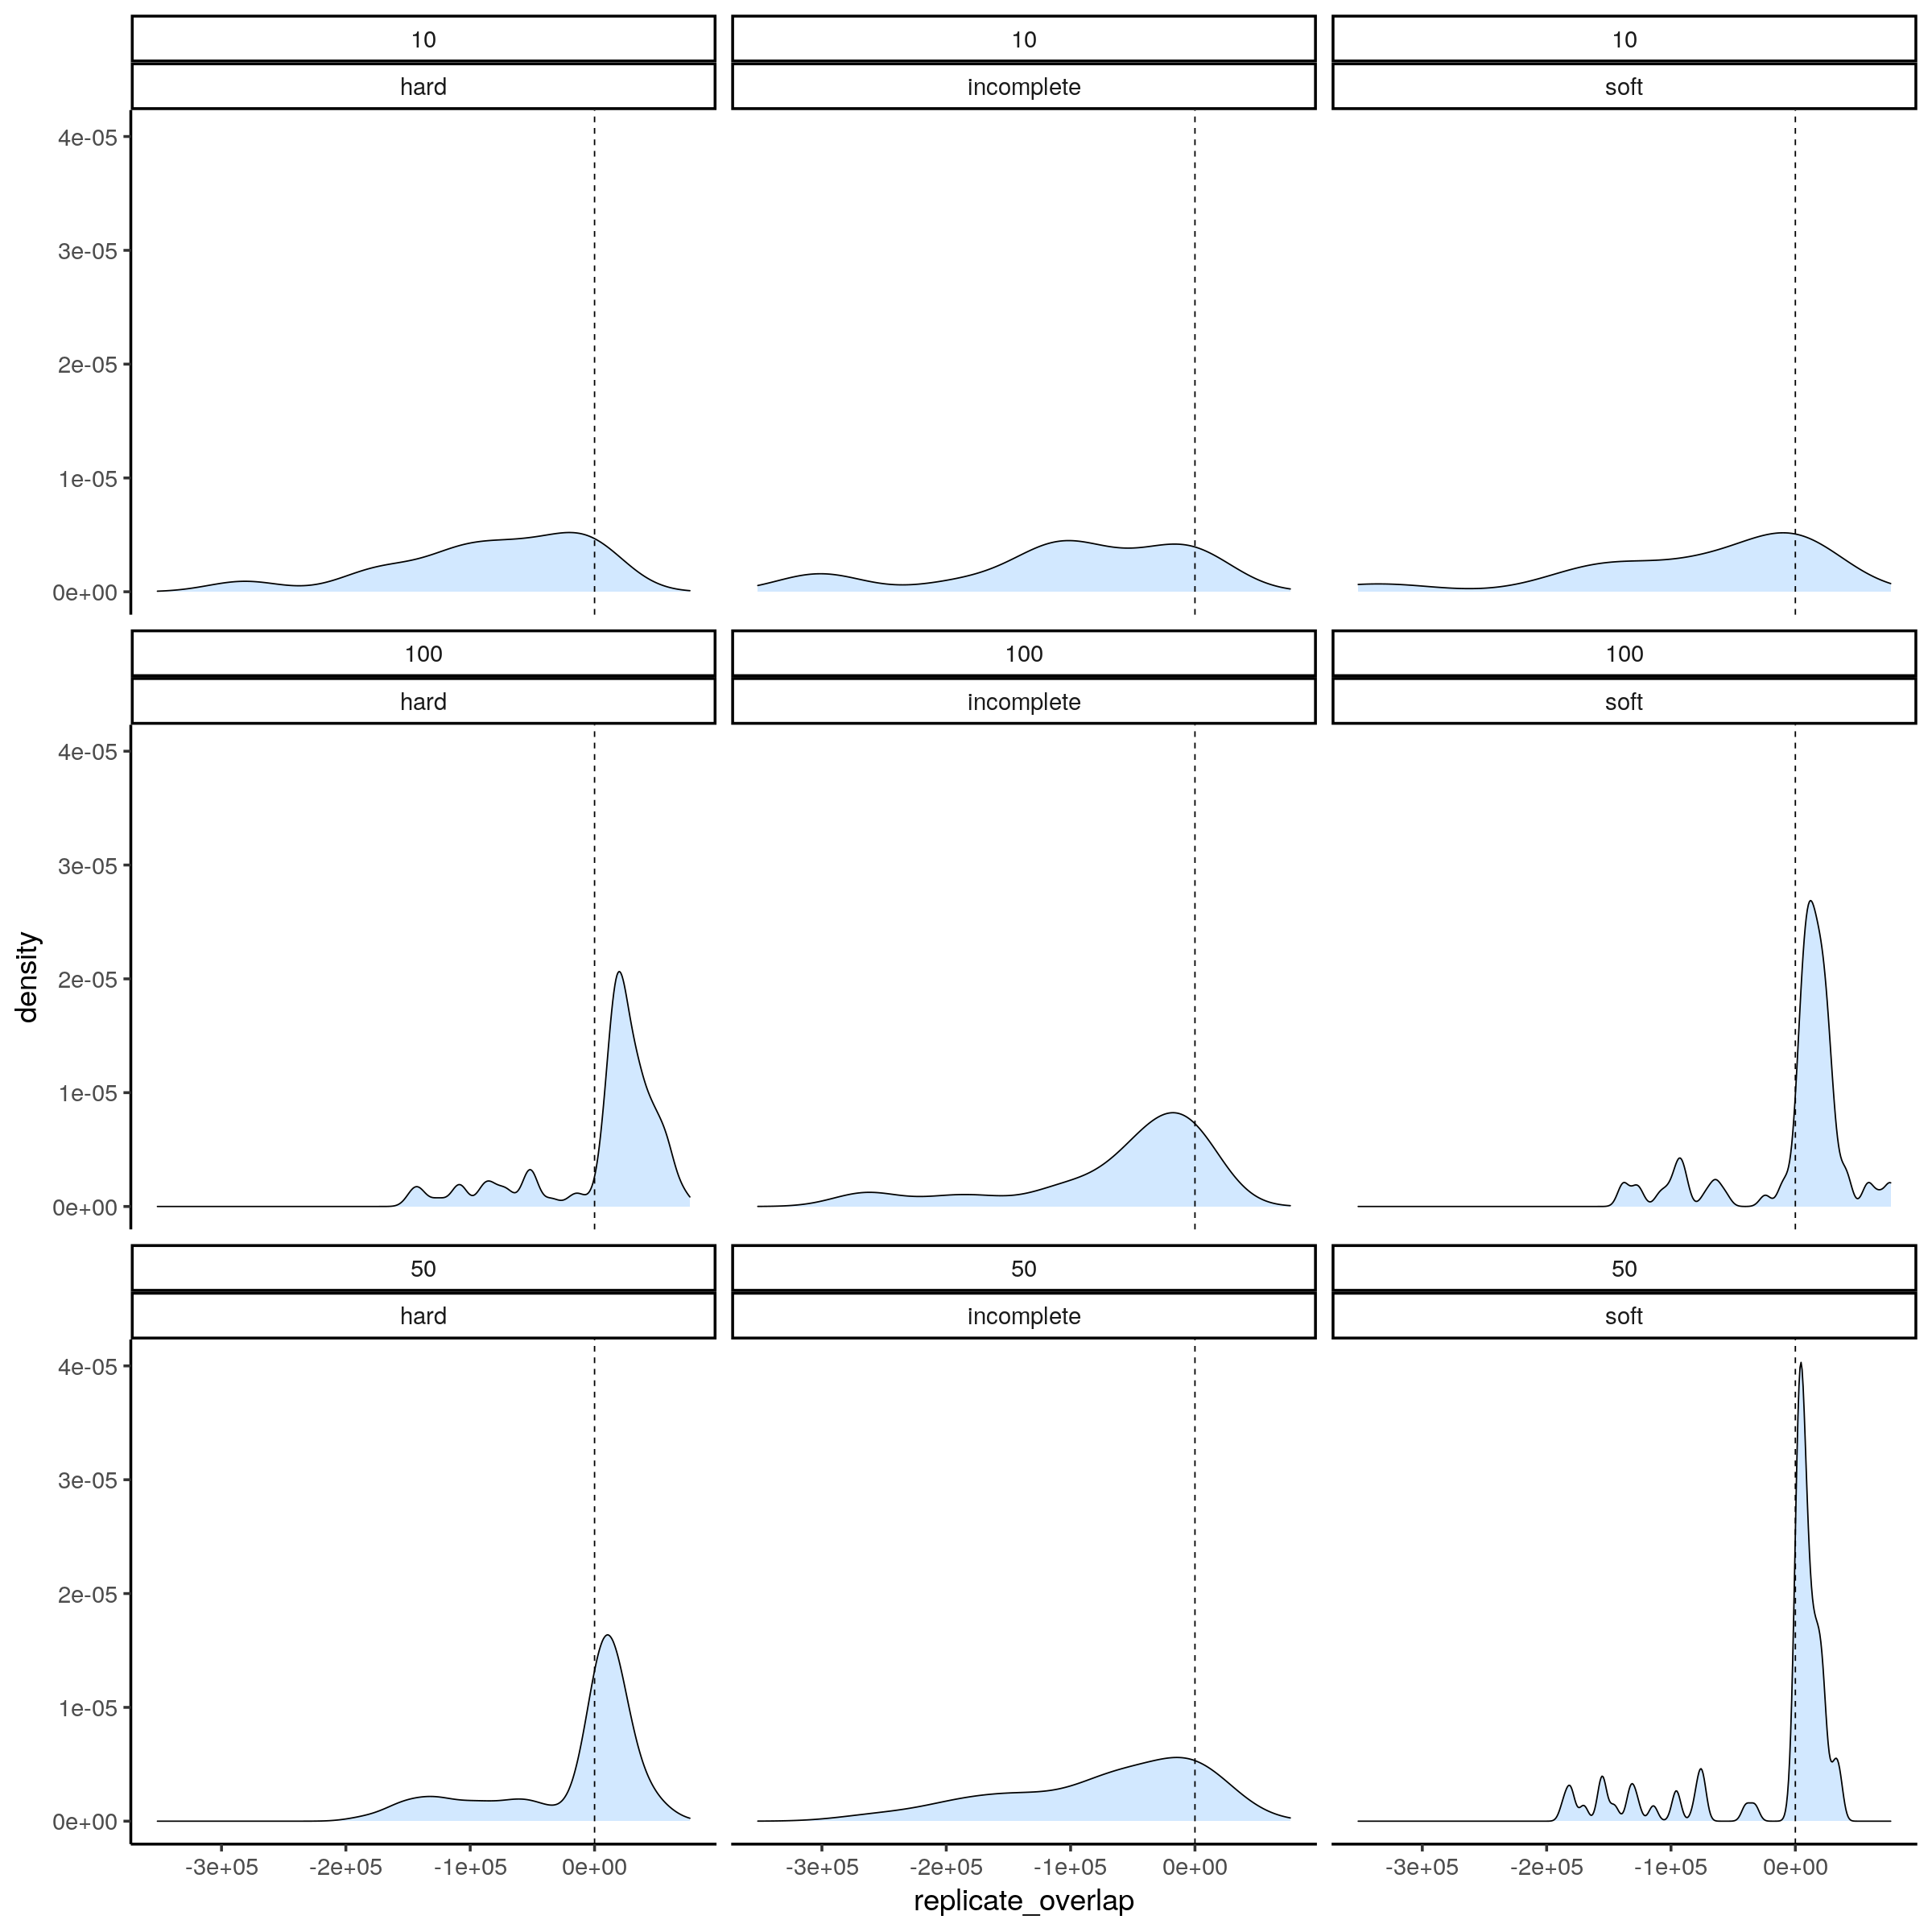

In [6]:
options(repr.plot.width=20, repr.plot.height=20)

#agreement between subreps 

#how to check similarity between two?
#Maybe number of shared bps?
#i.e.
# start end rep

#  s----------e
#                    s--------e

#so difference between min end and max start?

reps_df <- full_df %>% 
    group_by(seed1, seed2, start_freq, end_freq, alpha, sim_type, sweep_group) %>% 
    mutate(count = length(sub)) %>% 
    filter(!is.na(sweep_group), count > 1) %>%
    mutate(replicate_overlap = (min(end) - max(start)), scaled_overlap = replicate_overlap / mean(sweep_size))


reps_df %>% 
    ggplot(aes(x = replicate_overlap)) + 
    geom_density(fill = "dodgerblue", alpha = 0.2) + 
    geom_vline(xintercept = 0, lty = 2) +
    facet_wrap(~alpha + sim_type, scales = "fixed")
    